# Details

Name: **Hakim BOULAHYA**

ID: 000391737

Section: Computer Science at **ULB**

# Introduction

In this work we will focus on techniques to classify linearly separable data. That is we focus on the following algorithms: the **Perceptron Learning Algorithm (PLA)** (1.4) and **Adaptive Linear Neuron Algorithm** (1.5). 


# Imports

Import the module *numpy* for the mathematical function and the module *matplotlib* to generate plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Random generation of datasets

To generate a random datasets as requested in the problems, we have first to make sure that our data are linearly separable, or the algorithms will not be able to converge and ends.

## Linear function

Let's define a function that will generate a random linear function $ax + b$. The value $a$ and $b$ are chosen using an uniform distribution in $[-bound, bound]$.

In [2]:
def generate_lin_fct(bound=10):
    a = np.random.uniform(-bound, bound)
    b = np.random.uniform(-bound, bound)
    return a, b

To compute the side of a point with respect to a linear function $f$, we calculate the cross product $\overrightarrow{uv} \times \overrightarrow{up}$ where $u, v$ are two end points (representing the line $f$) and a point $p$. All points with the cross product that have the same sign, will be on the same side.

In [3]:
def get_class(f, xp, yp):
    """
    :param f: Linear function that separate the points on the plane
    :param xp: xp coordinate of the point to classify
    :param yp: yp -
    :return: -1 or 1 depending on the side
    """
    a, b = f
    # 2 points on the line u, v
    xu, yu, xv, yv = 0, b, 1, a + b
    # Getting sign using cross product
    uv = [xv - xu, yv - yu]
    up = [xp - xu, yp - yu] 
    return -1 if np.cross(uv, up) < 0 else 1

## Linearly separable dataset

Let's define a functions to generate random points on the plane. To avoid any confusion, we will refer to the vectors $x$ in the book as the array *x_train* and the labels of each data as
the array *y_train*. When we refer to a point on the plane we usually use the convention $(x, y)$.

To generate random datasets we need different values:

- The size of the datasets
- the bound of the coordinates (to make sure that all the points can be visualized in the same area in the plots)
- the dimension $d$ of the space where each points belongs to $\mathbb{R}^d$. For the moment we only consider 2 dimensional space, and will use another method for higher dimension in exercice (f).

Each generated point will be assigned the label $1$ or $-1$, with respect to the side of function $f$, using the function
*get_class* from the section above.

Finally, we standardize all of our generated points point by adding the bias constante coordinate $x_0 = 1$.

**Remark**: One could say that using a randomly generated weight vector $w$ and use the sign of the signal $w^Tx$ could be a better method to generate a linearly separable dataset. This is actually what we do here implictly by generating the linear function $ax + b$. In the last exercices, we will indeed explicitly use the methods with the weight vector and the signal as it is more suited for high dimensions.

In [4]:
def gen_rand_ds_2d(f, size=20, bound=10):
    dim = 2
    x_train = np.random.uniform(-bound, bound, size=(size, dim))
    y_train = np.array([get_class(f, *point) for point in x_train])
    x_train = np.insert(x_train, 0, 1, axis=1) # insert bias cst
    return x_train, y_train

# Plots

We define some functions to show plots. *plot_points()* takes a datasets and scatter the points
on the plane. Points with the same label (i.e. same side) will have the same color (green or red). *plot_lin()* plots a linear function *ax + b*.

In [5]:
def plot_points(dataset, marker='o'):
    x_array, y_array = dataset
    x_array = x_array[:, 1:]  # remove bias cst
    cmap = ['red' if i < 0 else 'green' for i in y_array]
    plt.scatter(*zip(*x_array), c=cmap, s=20, marker=marker)

In [6]:
def plot_lin(a, b, bound=10, label=None):
    x = np.linspace(-bound, bound, 1000) # x coord to calc. ax+b
    plt.plot(x, a*x + b, label=label, linewidth=1)

The *plot_result* is a wrapper to plot a dataset and the original linear function $f$ besides the hypothesis $g$. This allow use to ease the plotting in the exercices answers.

In [48]:
def plot_result(dataset, bound, f=None, g=None, other_dset=None, plane_bound=None, title=None):
    """
    Plot (and show) the 2D plane with f and g (linear function),
    and the points of the dataset colored using their respecting labels.
    The axis are limited to [-bound, bound]
    :param f: Linear function (original)
    :param g: Linear function (predicted)
    :param dataset: x_train and y_train
    :param bound: axis limits
    """
    if f is not None: plot_lin(*f, label='f')
    if g is not None: plot_lin(*g, label='g')
    if title is not None: plt.title(title)
    plt.legend()
    plot_points(dataset, marker='o')
    if other_dset is not None: plot_points(other_dset, marker='x')
    plane_bound = bound if plane_bound is None else plane_bound
    plt.ylim(-plane_bound, plane_bound)
    plt.xlim(-plane_bound, plane_bound)
    plt.show()

# Perceptron Learning Algorithm

## Weights related function

Before implementing the PLA, we will first implement functions that will make use of the datasets and the weights.

### Prediction

To be able to predict, based on a weights vector $w$, the class of a point (that is $-1$ or $-1$), the *predict(w, x)* function compute the inner product between the column vector $w$ and $x$, that is $w = (w_0, w_1, .., w_n)$ where $w_0$ is the bias. The column vector $x = (x_0, x_1, .., x_n)$ is a sample where $x_0 = 1$ as we consider the bias as a weight. The result computation is the sign of the inner product $w^Tx$.

In [8]:
def predict(w, x):
    value = np.inner(w, x)
    return 1 if value > 0 else -1

### Generate $g$ from $w$

To compare the learned classification by the PLA, when using elements from  2 dimensional space $\mathbb{R}^2$, it is necessary to generate the learned linear functions $g$, to compared it with $f$. To do so, we resolve the equation $w_0 + w_1x_1 + w_2x_2 = 0$ for two points $(x_1, 0)$ and $(0, x_2)$. We ommitted $x_0$ as it is the constant 1. We have:
- $x_1 = \frac{-w_0}{w_1}$ when $x_2 = 0$
- $x_2 = \frac{-w_0}{w_2}$ when $x_1 = 0$

We have two points on the line of the linear function: $p = (-\frac{w_0}{w_1}, 0)$ and $q = (0, -\frac{w_0}{w_2})$, therefore $g = ax + b$ with $a = -\frac{q_y}{p_x}$ and $b = q_y$ 


In [9]:
def weights_lin_funct(w):
    """
    Return the linear function ax+b from weights generated by PLA
    :param w: weights
    :return: (a, b) of g function
    """
    p = (-np.divide(w[0], w[1]), 0)
    q = (0, -np.divide(w[0], w[2]))
    return -np.divide(q[1], p[0]), q[1]

## Misclassified selection

We implemented two way to allow the PLA to choose a misclassified sample. *select_deterministric()* return the first misclassified element, where *select_random_miscls()* will randomly choose an element from all the misclassified element. An element is considered misclassified when its prediction is different from its label, that is $sign(w^Tx_i) \neq y_i$.

In [10]:
def select_deterministic(w, x_train, y_train):
    """
    Select the first misclassified element.
    :return: misclassified element or -1 if no such element
    """
    i, j = -1, 0
    while i == -1 and j < len(x_train):
        prediction = predict(w, x_train[j])
        if prediction != y_train[j]:
            i = j
        j += 1
    return (x_train[i], y_train[i]) if i != -1 else None

In [11]:
def select_random_miscls(w, x_train, y_train):
    """
    Select randomly a misclassified element.
    :return: random misclassified element or -1 if no such element
    """
    misclassified = [i for i in range(len(x_train)) if predict(w, x_train[i]) != y_train[i]]
    i = np.random.choice(misclassified) if len(misclassified) != 0 else -1
    return (x_train[i], y_train[i]) if i != -1 else None

In [12]:
def select_misclassified(w, dataset, random=False):
    select_funct = select_random_miscls if random else select_deterministic
    return select_funct(w, *dataset)

# Problem 1.4: Study the Perceptron Learning Algorithm

## Update rule

Let's first define the update rule used in the PLA that we have to implement for this problem.
The standard update rule is the following:
$w(t+1) = w(t) + y(t) \cdot x(t)$ where (x(t), y(t)) is a misclassified element.

In [13]:
def standard_update_rule(w, x_miscls, y_miscls):
    return np.add(w, np.multiply(x_miscls, y_miscls))

## PLA

The PLA implementation process as follow:
- Initialize the weights vector $w = [0, .., 0]$ of size $dimension + 1$, where dimension is the dimension of the space $\mathbb{R}^d$. Note that the initial values of the vector $w$ is arbitrary and was used as it is the convention of this algorithm.
- while a misclassified element exists, take one using the deterministic or random selection, and update $w$ using the selected $(x(t), y(t))$.

The misclassified selection will be defined depending on the question we try to answer as the PLA
function take in parameter the selection method.

In [14]:
def pla(dataset, dim=2, random_select=False):
    w = np.zeros(dim + 1)  # n els. + bias
    finished, t = False, 0
    while not finished:
        data = select_misclassified(w, dataset, random=random_select)
        if data is not None:
            x_sample, y_sample = data
            w = standard_update_rule(w, x_sample, y_sample)
        else:
            finished = True
        t += 1
    return w, t

## (a) Generate a linearly separable set of size 20

We generate a random linear function $f$, and a dataset of 2D space elements of size 20. For each points $(x, y)$ of the dataset we bounds the values like: $x,y \in [-10, 10]$ .

In [100]:
f = generate_lin_fct()
dsize, bound, dim = 20, 10, 2
dataset = gen_rand_ds_2d(f, size=dsize, bound=bound)

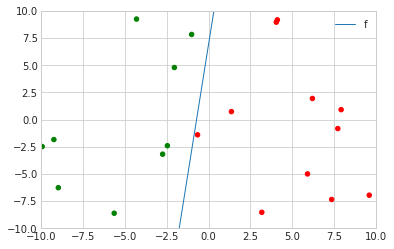

In [101]:
plot_result(dataset=dataset, bound=bound, f=f)

## Next exercices results
Since the next exercices (b to e) must plot the same results and just depends on different dataset, the next snippet plots and prints the results required for those exercices

In [73]:
def run_pla_on(dataset):
    global f, bound, dim
    w, t = pla(dataset, dim=dim, random_select=False)
    g = weights_lin_funct(w)
    # print(f"hypthesis g (weights): {w}")
    plot_result(dataset=dataset, bound=bound, f=f, g=g)
    print(f"Number of updates: {t}")

## (b) PLA on the dataset

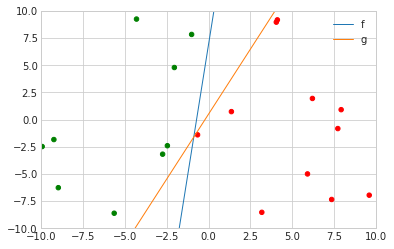

Number of updates: 8


In [102]:
run_pla_on(dataset)

The hypothesis $g$ is close enough to $f$ to be able to classify the samples in the training dataset. As shown on the figure above, any point between $g$ and $f$ *can* be misclassified (e.g. a red point will be considered as a green point or the opposite).
Actually if the zone between the two classes is big, the inaccurracy of the hypothesis will be higher. Indeed the goal of the algorithm in to *move* the boundary $g$ based on misclassified elements, which will end the algorithms event if the boundary $g$ does not converge to $f$. That is more points of the two classes are closed (i.e. they are tangent to $f$) will make the convergence of the hypothesis $g$ more accurate.

## (c) another dataset of size 20

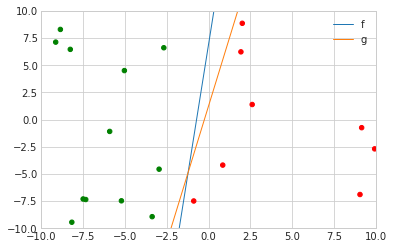

Number of updates: 14


In [109]:
dataset = gen_rand_ds_2d(f, size=20, bound=bound)
run_pla_on(dataset)

As explained in (b), here the convergence of $f$ is very close to $g$. Indeed when elements of the two classes are closed to the function $f$, more accurate is $g$. We can also observe that the number of updates is higher for this dataset, because it is harder to move the hypothesis without 'messing up' classification of other elements.

## (d) size = 100

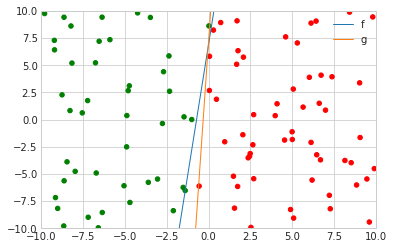

Number of updates: 234


In [108]:
dataset = gen_rand_ds_2d(f, size=100, bound=bound)
run_pla_on(dataset)

The comparison that has been made between with (b) and (c) is equivalent here. Because we have more data, there is a higher probability to have close data to $f$, which means that $g$ will probably be more accurates. Because of bigger datasets, there is more elements to classify, which also increase number of updates.

## (e) size = 1000

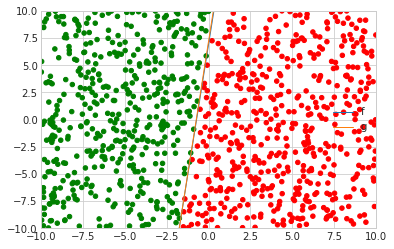

Number of updates: 309


In [112]:
dataset = gen_rand_ds_2d(f, size=1000, bound=bound)
run_pla_on(dataset)

We have a lot more data than with (b). Therefore it is *harder* to classify all elements. Since $f$ is tangent with different points from both classes, we can see that the accuracy of $g$ is nearly perfect. Another *downside* of a big datasets in the number of updates which is extremly higher than with the (b) execution that as only 20 data.

In addition to this results above, let's add another result. Below we plot an histogram of running time for the same dataset of size 1000 in 2 dimension, where a bar represent the running time of an experiment.

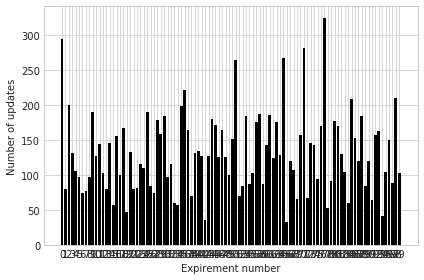

In [113]:
n_exp = 100
updates = []
for i in range(n_exp):
    w, t = pla(dataset, dim=2, random_select=True)
    updates.append(t)
    
fig, ax = plt.subplots()
x_pos = np.arange(n_exp)
ax.bar(x_pos, updates, align='center', alpha=1, color='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
plt.xlabel("Expirement number")
plt.ylabel("Number of updates")
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

Again, we run a same number of experiments for a smaller dataset of size 500.

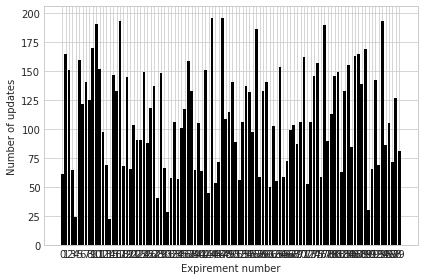

In [117]:
dataset = gen_rand_ds_2d(f, size=500, bound=bound)

updates = []
for i in range(n_exp):
    w, t = pla(dataset, dim=2, random_select=True)
    updates.append(t)
    
fig, ax = plt.subplots()
x_pos = np.arange(n_exp)
ax.bar(x_pos, updates, align='center', alpha=1, color='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
plt.xlabel("Expirement number")
plt.ylabel("Number of updates")
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

We can see here that the size of the dataset has merly no impact in the number of updates that the algorithm takes to find an hypothesis.

## (f) Dataset on $\mathbb{R}^{10}$

Our approach in the previous exercice to generate our dataset is highly connected to a 2 dimensionnal space, because the method used to classify the data is to use the cross product of vectors. 

For a higher dimension , we will use the definition of the perceptron to generate a weights vector of size $d+1$. We will then generate data of dimension $d$ and the classification will be based on the sign of the signal $w^Tx$ of the generated weights vector.

In [39]:
def gen_rand_ds_highdim(size=20, bound=10, dim=2):
    w = np.random.uniform(-bound, bound, size=dim+1)
    x_train = np.random.uniform(-bound, bound, size=(size, dim))
    x_train = np.insert(x_train, 0, 1, axis=1) # insert bias cst
    y_train = np.array([predict(w, x) for x in x_train]) # predict is the sign of the inner product
    return x_train, y_train

In [40]:
dim = 10
dsize = 1000
dataset = gen_rand_ds_highdim(size=1000, bound=bound, dim=dim)

In [41]:
w, t = pla(dataset, dim=dim, random_select=False)
# print(f'learned w = {w}')
print(f"Number of updates: {t}")

Number of updates: 3480


## (g) 100 experiments in $\mathbb{R}^{10}$

In this question, we will run 100 experiments on the dataset generated in (f). The hisogram below show the number of updates for each run of the PLA.

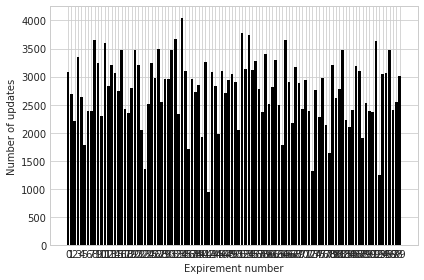

In [42]:
n_exp = 100
updates = []
for i in range(n_exp):
    w, t = pla(dataset, dim=10, random_select=True)
    updates.append(t)
    
fig, ax = plt.subplots()
x_pos = np.arange(n_exp)
ax.bar(x_pos, updates, align='center', alpha=1, color='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
plt.xlabel("Expirement number")
plt.ylabel("Number of updates")
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

Let's run the same number of experiments but with a smaller dataset of size 500.

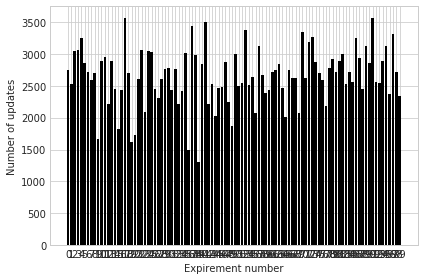

In [120]:
dataset = gen_rand_ds_highdim(size=500, bound=bound, dim=10)
n_exp = 100
updates = []
for i in range(n_exp):
    w, t = pla(dataset, dim=10, random_select=True)
    updates.append(t)
    
fig, ax = plt.subplots()
x_pos = np.arange(n_exp)
ax.bar(x_pos, updates, align='center', alpha=1, color='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(x_pos)
plt.xlabel("Expirement number")
plt.ylabel("Number of updates")
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

Again, here we see that the dataset size has merly no impact on the number of updates required by the algorithm to get $g$.

## (h) Conclusion


### Running time

We learn from the histograms of exercices (e) and (g) that when taking in consideration the size of the dataset and the dimension, the number of updates for the PLA to be able to find a hypothesis $g$ depends highly on the dimensions and less on the dataset size. Indeed we can see in (e) that for two datasets of different size (1000 and 500) in 2 dimension, the number of updates necessary to reach a hypothesis $g$ stays around the same limits (~$250$). Where with a bigger dimension $d = 10$ and datasets of same size, the number of updates is bigger. One could say that the number of updates is more related to dimension and less to the dataset size.

### Accuracy

Regarding the accuracy of the hypothesis, we conclude that it depends more on the datasets size and less on the dimensions. The precision rely more on the locations of the points, when computing the signal $w^Tx$, of the datasets in the dimensions, and less on the size of the dimension itself.

# Problem 1.5: Adaline

## Some util functions

In [43]:
def signal(w, x):
    return np.inner(w, x)

def adaline_update_rule(w, eta, x_sample, y_sample):
    sminusy = np.subtract(y_sample, signal(w, x_sample))
    etasy = np.multiply(eta, sminusy)
    return np.add(w, np.multiply(x_sample, etasy))

Random element selection (from all elements, not only misclassified):

In [44]:
def select_random(x_train, y_train):
    i = np.random.randint(len(x_train))
    return (x_train[i], y_train[i])

$\frac{1}{n} \sum_{n=1}^{N}{\| g(x_n) \ne f(x_n) \|}$ where $\| condition \|$ is equal to 1 when the condition is true.

In [45]:
def error_rate(w, x_test, y_test):
    size, error = len(x_test), 0
    for i in range(size):
        if predict(w, x_test[i]) != y_test[i]:
            error += 1
    return np.around(np.divide(error, size), 2)

## Adaline algorithm

The Adaptive linear neuron algorithm works as follow, at each iteration:

- Select a random sample $(x(t), y(t))$
- Compute the signal $s(t) = w^Tx(t)$
- if $y(t)\cdot s(t) \le 1$, then update w using the following rule:
    $w(t+1) = w(t) + \eta \cdot (y(t) - s(t)) \cdot x(t)$
    
As the next value of the weight vector depends on its initialisation, using a null vector at the beginning will not make the algorithm to be able to update itself, as the next value depends on the signal and the weight vector. In oppose to PLA, we will here initialise $w$ with a vector of value 1. This of course doesn't change the ability of the algorithm to find  a weight vector that works because within the infinite space of all weights vectors, a perceptron algorithm will always manage to find a weight vector for linearly separable data.

Note that when the learning rate $\eta$ is high, the weights vector can take big value. To face this problem, $w$ will be initialize using *longdouble* datatype.

In [46]:
def adaline(dataset, eta, nupdates=1000, dim=2):
    bias = -1
    w = np.ones(dim, dtype=np.longdouble)
    w = np.insert(w, 0, -bias) # insert bias cst as w0
    for t in range(nupdates):
        x_sample, y_sample = select_random(*dataset)
        sy =np.multiply(signal(w, x_sample), y_sample)
        if sy <= 1:
            w = adaline_update_rule(w, eta, x_sample, y_sample)
    return w

## Dataset and functions for the following exercices

We generate two datasets in space $\mathbb{R}^2$ within limits $[-10, 10]$:
- One training dataset of size 100
- One test dataset of size 10,000

As our results and discussions for the following exercices highly depends on the generated dataset, we defined a random seed.

**Remark**: Because we are using python, it can be the case that when running the PLA/Adaline algorithms, overflows can occurs. As explained in above, we change the numpy datatype to a 128bits float, which improve a little bit the probability to avoid an overflow, but re-running can cause the algorithm to not be able to find a good $w$ due the overflow. This said, it is usually possible to find an hypothesis $g$.

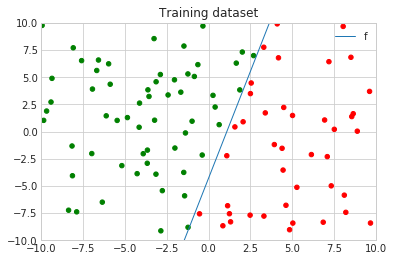

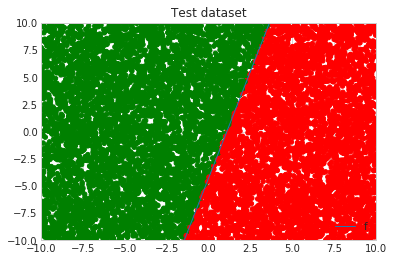

In [49]:
np.random.seed(123)
bound = 10
f = generate_lin_fct()
train_dset = gen_rand_ds_2d(f, size=100, bound=bound)
test_dset = gen_rand_ds_2d(f, size=10000, bound=bound)
plot_result(f=f, dataset=train_dset, bound=bound, title="Training dataset")
plot_result(f=f, dataset=test_dset, bound=bound, title="Test dataset")

The next exercices follow the same pattern, therefore the next function implement the process to get the results for those exercices.

In [50]:
def run_adaline_on(train_dset, test_dset, eta):
    w = adaline(train_dset, eta, nupdates=1000, dim=2)
    g = weights_lin_funct(w)
    plot_result(f=f, g=g, dataset=train_dset, bound=bound, plane_bound=10)
    print(f'Error: {error_rate(w, *test_dset) * 100}%')

## (a) $\eta = 100$

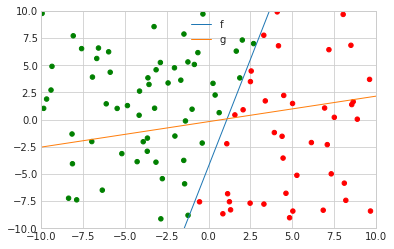

Error: 38.0%


In [52]:
run_adaline_on(train_dset, test_dset, eta=100)

## (b) $\eta = 1$

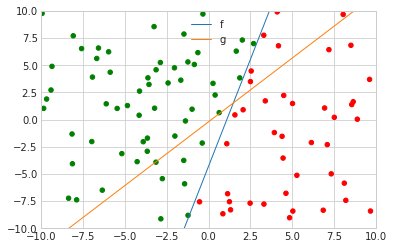

Error: 16.0%


In [54]:
run_adaline_on(train_dset, test_dset, eta=1)

## (c) $\eta = 0.01$

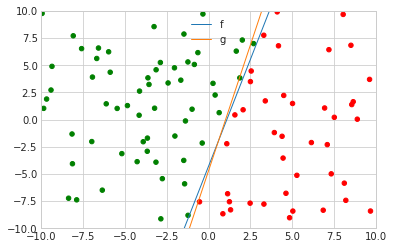

Error: 1.0%


In [55]:
run_adaline_on(train_dset, test_dset, eta=0.01)

## (d) $\eta = 0.0001$

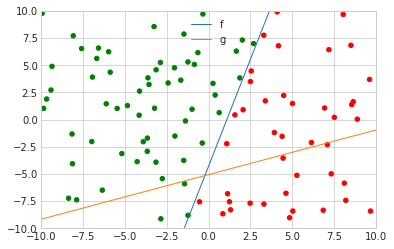

Error: 33.0%


In [58]:
run_adaline_on(train_dset, test_dset, eta=0.0001)

## (e) Results discussion

Let's first say that the following discussion can only be applied to the results above, and probably do not reflect the general behaviour. As we ran only one expirement. We will try to enrich this discussion by running some experiments at the end of this section.

The first noticeable result is that the learning rate $\eta = 0.01$ is always the most accurate hypothesis of $g$, where the error is very small. When $\eta = 100$ and $\eta = 1$ we have a higher error rate, but we can observe that, usually, the hypothesis $g$ convergence is better with $\eta = 1$. With smaller $\eta$ values $0.01$ and $0.001$ we have two observations: $\eta = 0.1$ is highly accurate, where $\eta = 0.0001$ has a high error rate. But a small difference compared to the higher learning rate $\eta = 1$ and $100$, is that the hypothesis $g$ made by small learning rates are often identical, which could be the sign that the error rate will be more constant when running multiple expirements for such learning rates.

To analyze more our observartion, we will run some expirements. For each value of $\eta$, we compute the mean and the standard deviation of the error rates of 100 expirements.

In [59]:
def adaline_exp(n_exp, eta):
    """
    Return means and standard deviations of the errors rate
    of <n_exp> experiments using <eta> as a learning rate.
    """
    errors = []
    for i in range(n_exp):
        w = adaline(train_dset, eta, nupdates=1000, dim=2)
        errors.append(error_rate(w, *test_dset))
    return np.around(np.mean(errors), 4), \
           np.around(np.std(errors), 4)

In [60]:
# We ignore overflow runtime warnings, and will ignore those expirements
import warnings
warnings.simplefilter("ignore")

results, n_exp = list(), 100
results.append(adaline_exp(n_exp, eta=100))
results.append(adaline_exp(n_exp, eta=1))
results.append(adaline_exp(n_exp, eta=0.01))
results.append(adaline_exp(n_exp, eta=0.0001))
results_names = ('100', '1', '0.01', '0.0001')

The plot below shows that indeed, the learning rate $\eta = 0.1$ provides an accurate hypthesis $g$ as the mean error is small.
We can also observe that with small learning rate, the standard deviation is very low. Where it is considerably high for the bigger learning rates.

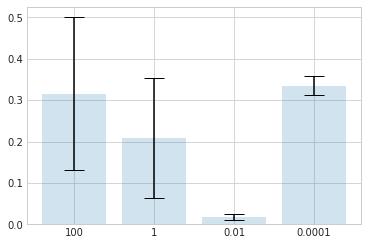

In [61]:
means, stds = map(list, zip(*results))
fig, ax = plt.subplots()
x_pos = np.arange(len(results))
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.2, ecolor='black', capsize=10)
ax.set_xticks(x_pos)
ax.set_xticklabels(results_names)
ax.yaxis.grid(True)
# plt.
# plt.tight_layout()
plt.show()